# Kerasの使い方

## 参考資料

 - [詳解ディープラーニング 第2版 (Compass Books)](https://www.amazon.co.jp/gp/product/B081RN1Z9C/ref=ppx_yo_dt_b_d_asin_title_o00?ie=UTF8&psc=1)
 - [TensorFlow, Kerasの基本的な使い方（モデル構築・訓練・評価・予測） | note.nkmk.me](https://note.nkmk.me/python-tensorflow-keras-basics/)
 - [Keras: Pythonの深層学習ライブラリ](https://keras.io/ja/)
 - [Neural Networkでの失敗経験やアンチパターンを語る - のんびりしているエンジニアの日記](https://nonbiri-tereka.hatenablog.com/entry/2016/03/10/073633)

## データの準備

In [158]:
import pandas as pd
from sklearn.datasets import fetch_california_housing


dataset = fetch_california_housing()
teacher_ser = pd.Series(dataset.target, name="カルフォルニアの住宅価格")
feature_df = pd.DataFrame(dataset.data, columns=dataset.feature_names)

In [159]:
teacher_ser.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: カルフォルニアの住宅価格, dtype: float64

In [160]:
feature_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [161]:
from sklearn.model_selection import train_test_split


train_feature_df, test_feature_df, train_teacher_ser, test_teacher_ser = train_test_split(feature_df, teacher_ser)

In [162]:
# データの正規化

平均 = train_feature_df.mean()
標準偏差 = train_feature_df.std()

train_normed_feature_df = (train_feature_df - 平均) / 標準偏差
test_normed_feature_df = (test_feature_df - 平均) / 標準偏差

## モデルの構築 

 - [活性化関数 - Keras Documentation](https://keras.io/ja/activations/)
 - [正則化 - Keras Documentation](https://keras.io/ja/regularizers/)
 - [レイヤーの重み初期化 - Keras Documentation](https://keras.io/ja/initializers/)

### Sequential API : シンプルな一直線のモデルを構築可能

In [163]:
import tensorflow as tf


特徴量の数 = len(train_normed_feature_df.keys())
モデルの名前 = 'regression'

多層ネットワークモデル = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(特徴量の数, ), name="input_layer"),
    tf.keras.layers.Dense(units=64, activation='relu', name="internal_layer_1"),
    tf.keras.layers.Dense(units=64, activation='relu', name="internal_layer_2"),
    tf.keras.layers.Dense(1, activation="relu", name="output_layer")
], name=モデルの名前)

In [164]:
多層ネットワークモデル.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Flatten)        (None, 8)                 0         
_________________________________________________________________
internal_layer_1 (Dense)     (None, 64)                576       
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
internal_layer_2 (Dense)     (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


### Subclassing API (Model Subclassing) : 最も柔軟にモデルを構築可能

In [85]:
class MultiLayerNenuralNet(tf.keras.Model):
    def __init__(self):
        super(MultiLayerNenuralNet, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(10, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.2)

    def call(self, x, training=False):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=training)
        return x

多層ネットワークモデル = MultiLayerNenuralNet()

## 学習プロセスの設定

 - [最適化 - Keras Documentation](https://keras.io/ja/optimizers/)
 - [損失関数 - Keras Documentation](https://keras.io/ja/losses/)
 - [評価関数 - Keras Documentation](https://keras.io/ja/metrics/)

In [165]:
最適化アルゴリズム = 'adam'
損失関数 = 'mse'
評価関数_list  = ['mse', 'mae']

多層ネットワークモデル.compile(
    optimizer=最適化アルゴリズム,
    loss=損失関数,
    metrics=評価関数_list
)

In [166]:
多層ネットワークモデル.predict(train_normed_feature_df[:10])

array([[0.12266522],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.19362313],
       [0.0168501 ],
       [0.        ],
       [0.        ],
       [0.10118583],
       [0.23680747]], dtype=float32)

## 学習

 - [コールバック - Keras Documentation](https://keras.io/ja/callbacks/)

In [167]:
from keras.callbacks import EarlyStopping


バッチサイズ = 100
エポック数 = 1000
# コールバックs = []
コールバックs = [EarlyStopping(monitor='val_loss', patience=10)]  # 最低10エポックはパラメーターを更新する

history = 多層ネットワークモデル.fit(
    train_normed_feature_df, train_teacher_ser, 
    validation_split=0.2,
    batch_size=バッチサイズ,
    epochs=エポック数,
    callbacks=コールバックs
)
history

Train on 12384 samples, validate on 3096 samples
Epoch 1/1000
12384/12384 [==============================] - 1s 75us/step - loss: 1.6623 - mean_squared_error: 1.6623 - mean_absolute_error: 0.9261 - val_loss: 0.7355 - val_mean_squared_error: 0.7355 - val_mean_absolute_error: 0.6107
Epoch 2/1000
12384/12384 [==============================] - 0s 25us/step - loss: 0.8683 - mean_squared_error: 0.8683 - mean_absolute_error: 0.6698 - val_loss: 0.5693 - val_mean_squared_error: 0.5693 - val_mean_absolute_error: 0.5329
Epoch 3/1000
12384/12384 [==============================] - 0s 23us/step - loss: 0.7333 - mean_squared_error: 0.7333 - mean_absolute_error: 0.6076 - val_loss: 0.5125 - val_mean_squared_error: 0.5125 - val_mean_absolute_error: 0.5127
Epoch 4/1000
12384/12384 [==============================] - 0s 21us/step - loss: 0.6257 - mean_squared_error: 0.6257 - mean_absolute_error: 0.5674 - val_loss: 0.4894 - val_mean_squared_error: 0.4894 - val_mean_absolute_error: 0.4882
Epoch 5/1000
12384/

Epoch 36/1000
12384/12384 [==============================] - 0s 26us/step - loss: 0.3836 - mean_squared_error: 0.3836 - mean_absolute_error: 0.4362 - val_loss: 0.3575 - val_mean_squared_error: 0.3575 - val_mean_absolute_error: 0.4111
Epoch 37/1000
12384/12384 [==============================] - 0s 24us/step - loss: 0.3813 - mean_squared_error: 0.3813 - mean_absolute_error: 0.4351 - val_loss: 0.3622 - val_mean_squared_error: 0.3622 - val_mean_absolute_error: 0.4112
Epoch 38/1000
12384/12384 [==============================] - 0s 28us/step - loss: 0.3729 - mean_squared_error: 0.3729 - mean_absolute_error: 0.4270 - val_loss: 0.3528 - val_mean_squared_error: 0.3528 - val_mean_absolute_error: 0.4079
Epoch 39/1000
12384/12384 [==============================] - 0s 29us/step - loss: 0.3748 - mean_squared_error: 0.3748 - mean_absolute_error: 0.4297 - val_loss: 0.3566 - val_mean_squared_error: 0.3566 - val_mean_absolute_error: 0.4088
Epoch 40/1000
12384/12384 [==============================] - 0s 

12384/12384 [==============================] - 0s 29us/step - loss: 0.3378 - mean_squared_error: 0.3378 - mean_absolute_error: 0.4066 - val_loss: 0.3286 - val_mean_squared_error: 0.3286 - val_mean_absolute_error: 0.3930
Epoch 72/1000
12384/12384 [==============================] - 0s 22us/step - loss: 0.3380 - mean_squared_error: 0.3380 - mean_absolute_error: 0.4065 - val_loss: 0.3185 - val_mean_squared_error: 0.3185 - val_mean_absolute_error: 0.3885
Epoch 73/1000
12384/12384 [==============================] - 0s 26us/step - loss: 0.3321 - mean_squared_error: 0.3321 - mean_absolute_error: 0.4077 - val_loss: 0.3185 - val_mean_squared_error: 0.3185 - val_mean_absolute_error: 0.3922
Epoch 74/1000
12384/12384 [==============================] - 0s 26us/step - loss: 0.3451 - mean_squared_error: 0.3451 - mean_absolute_error: 0.4074 - val_loss: 0.3198 - val_mean_squared_error: 0.3198 - val_mean_absolute_error: 0.3909
Epoch 75/1000
12384/12384 [==============================] - 0s 30us/step - lo

In [168]:
学習推移_df = pd.DataFrame(history.history, index=history.epoch)
学習推移_df.head()

,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error
0,0.735461,0.735461,0.610736,1.662335,1.662335,0.926133
1,0.569292,0.569292,0.532936,0.868333,0.868333,0.669765
2,0.512515,0.512515,0.512670,0.733253,0.733253,0.607635
3,0.489423,0.489423,0.488216,0.625711,0.625711,0.567373
4,0.476343,0.476343,0.478463,0.593850,0.593850,0.549348


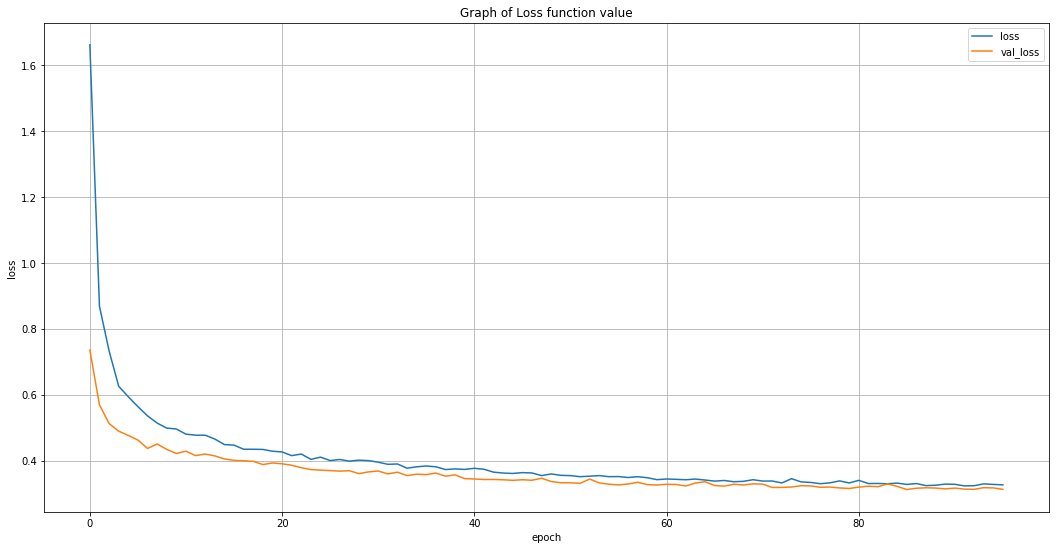

In [169]:
import matplotlib.pyplot as plt


plt.figure(figsize=(18, 9))
plt.title("Graph of Loss function value")
plt.plot(学習推移_df['loss'], label='loss')
plt.plot(学習推移_df['val_loss'], label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 評価

In [170]:
metrics = 多層ネットワークモデル.evaluate(test_normed_feature_df, test_teacher_ser)

5160/5160 [==============================] - 0s 35us/step


In [171]:
pd.Series(
    metrics,
    index=多層ネットワークモデル.metrics_names,
    name='評価指標'
)

loss                   0.274776
mean_squared_error     0.274776
mean_absolute_error    0.361868
Name: 評価指標, dtype: float64

## 予測

In [172]:
predicted_y_arr = 多層ネットワークモデル.predict(test_normed_feature_df)

In [173]:
predicted_y_arr[:, 0]

array([1.6296583, 1.767854 , 3.262125 , ..., 2.364806 , 3.1501303,
       3.4615464], dtype=float32)

In [174]:
predicted_y_ser = pd.Series(predicted_y_arr[:, 0], name="予測値")
predicted_y_ser.head()

0    1.629658
1    1.767854
2    3.262125
3    2.064524
4    1.510647
Name: 予測値, dtype: float32

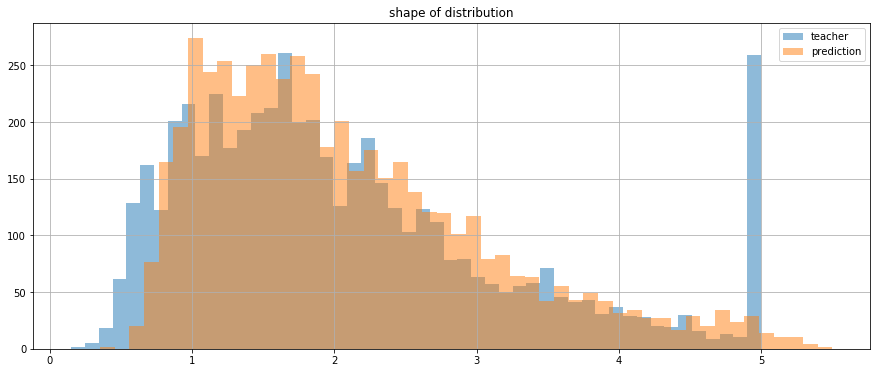

In [175]:
plt.figure(figsize=(15, 6))
plt.title("shape of distribution")
plt.hist(test_teacher_ser, bins=50, alpha=0.5, label='teacher')
plt.hist(predicted_y_ser, bins=50, alpha=0.5, label='prediction')
plt.legend()
plt.grid(True)
plt.show()

## 保存

In [70]:
多層ネットワークモデル.save('/Users/taiyou/Desktop/kerasの使い方モデル.h5')

## 復元

In [71]:
import tensorflow as tf


model = tf.keras.models.load_model('/Users/taiyou/Desktop/kerasの使い方モデル.h5')

In [72]:
model.predict(test_normed_feature_df)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)